In [1]:
import os
import cv2
import numpy as np
import random
import string
import time

In [2]:
#def encode_to_labels(txt):
	#dig_lst = []
#	df = pd.DataFrame(txt, columns=['words', 'numbers', 'orders'])
#	txt_df = df.drop(columns=['numbers', 'orders'])
#	labelencoder = LabelEncoder()
#	txt_df['word_numbers'] = labelencoder.fit_transform(txt_df['words'])
	#dig_lst.append(txt_df)
#	return np.asarray(txt_df)

char_list = string.ascii_letters+string.digits+string.punctuation

def encode_to_labels(tex):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(tex):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [1]:
txt = []
with open('../data/words.txt') as f:
    for line in f:
        if not line or line[0]=='#':
            continue
        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 9
        # GT text are columns starting at 9
        gtText = ' '.join(lineSplit[8:])
        txt.append(gtText)
print(len(txt)) 

115318


In [40]:
def resize_words(img, imgSize = (128, 32)):
    (wt, ht) = imgSize
    h, w = img.shape[:2]
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) 
    img = cv2.resize(img, newSize)
    mask = np.ones([ht, wt]) * 255
    mask[0:newSize[1], 0:newSize[0]] = img
    return cv2.resize(mask, imgSize, interpolation = cv2.INTER_AREA)

In [8]:
images = []
bad_images = []
rootdir = '../data/words_images'
for imgs in os.listdir(rootdir):
    #for img in imgs:
    img = cv2.imread(os.path.join(rootdir, imgs), 0)
    if img is None:
        bad_images.append(img)
        continue
    img = resize_words(img, imgSize = (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    images.append(img)
np.asarray(images).shape

(115318, 32, 128, 1)

In [17]:
# lists for training dataset
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
max_label_len = 0
i = 0
for text in txt:
    i += 1
    if len(text) > max_label_len:
            max_label_len = len(text)
            
    if i<=5766:
        valid_orig_txt.append(text)   
        valid_label_length.append(len(text))
        valid_input_length.append(31)
        valid_txt.append(encode_to_labels(text))
    else:
        orig_txt.append(text)   
        train_label_length.append(len(text))
        train_input_length.append(31)
        training_txt.append(encode_to_labels(text))        

print(np.asarray(valid_orig_txt).size)
print(np.asarray(valid_label_length).size)
print(np.asarray(valid_input_length).size)
print(np.asarray(valid_txt).size)
print(np.asarray(orig_txt).size)
print(np.asarray(train_label_length).size)
print(np.asarray(train_input_length).size)
print(np.asarray(training_txt).size)

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
5766
5766
5766
5766
109552
109552
109552
109552


In [18]:
valid_img = []
training_img = []
j = 0
for word in images:
    j += 1
    if j<=5766:
        valid_img.append(word)
    else:
        training_img.append(word)

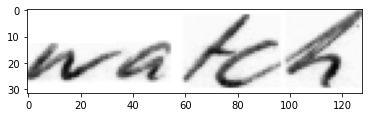

In [19]:
import matplotlib.pyplot as plt  
plt.imshow(training_img[100009], cmap='gray')

In [25]:
training_txt[100009]

[22, 0, 19, 2, 7]

In [26]:
orig_txt[100009]

'watch'

In [27]:
# pad each output label to maximum text length
from keras.preprocessing.sequence import pad_sequences
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [28]:
print(train_padded_txt.shape)
print(valid_padded_txt.shape)

(109552, 31)
(5766, 31)


In [29]:
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [30]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [31]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        5900

In [32]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [33]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [34]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [20]:
batch_size = 256
epochs = 15
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Train on 109552 samples, validate on 5766 samples
Epoch 1/15
 67584/109552 [=================>............] - ETA: 2:06:19 - loss: 14.7779

InvalidArgumentError: Not enough time for target transition sequence (required: 53, available: 31)43You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[{{node ctc/CTCLoss}}]]

In [36]:
act_model.load_weights('best_model.hdf5')

In [1]:
test_imag = resize_words(cv2.imread('C:/Users/luqman/Desktop/OCR Handwritten Recognition/Scanned doc text detection and segmentation/segmentation/word segment images/line_2.jpg/1.jpg', 0))

NameError: name 'resize_words' is not defined

In [2]:
plt.imshow(test_imag, cmap='gray')

NameError: name 'plt' is not defined

In [92]:
t_image = np.expand_dims(test_imag, axis = 2)
_image = t_image/255.
st_image1 = np.asarray(_image)
test_age2 = st_image1[np.newaxis]

In [93]:
test_age2.shape

(1, 32, 128, 1)

In [94]:
predict = act_model.predict(test_age2)
out = K.get_value(K.ctc_decode(predict, input_length=np.ones(predict.shape[0])*predict.shape[1], greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    #print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

predicted text = This

